In [1]:
!nvidia-smi

Mon Aug 19 08:30:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.04              Driver Version: 555.52.04      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:01:00.0 Off |                    0 |
| N/A   33C    P0             66W /  500W |       5MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Librerie importate

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D
import os
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

2024-08-19 08:30:31.372926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 08:30:31.387830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 08:30:31.392192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 08:30:31.404914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Gestione del dataset di immagini

#### Creazione di un dataframe per la gestione e suddivisione del dataset in training set, validation set e test set.

In [9]:
train_folder = 'alfabeto_muto_dataset'
all_data = []
for folder in os.listdir(train_folder):
    if folder == ".DS_Store":
        continue
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)

In [4]:
x_train,x_test = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_val = train_test_split(x_train, test_size= 0.25, random_state=42,stratify=x_train[['label']])

In [5]:
img_width, img_height = 64, 64
batch_size = 256
y_col = 'label'
x_col = 'path'
# no_of_classes = len(data_df[y_col].unique())


# ImageDataGenerator utile per normalizzare le immagini
datagen_train = ImageDataGenerator(
    rescale=1.0/255.0, 
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest',
    #validation_split=0.2
)

# Generare i dati di training 
train_generator = datagen_train.flow_from_dataframe(
    dataframe=x_train,
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=False,
)

# Creare il validation set
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=x_val, 
    x_col=x_col, 
    y_col=y_col,
    target_size=(img_width, img_height), 
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=False
)

# Creare il test set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=x_test, 
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 58725 validated image filenames belonging to 29 classes.
Found 19575 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


### Controllo sul bilanciamento del dataset

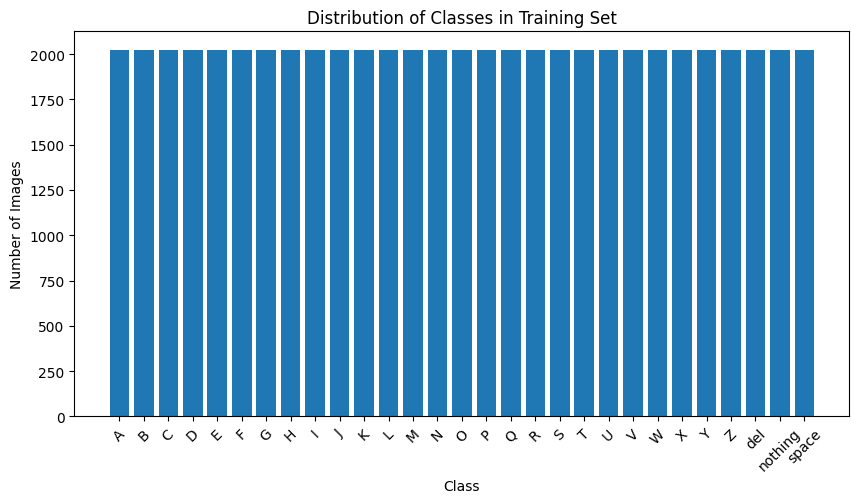

In [6]:

# Etichette delle classi dal generatore del training set
class_labels = train_generator.classes

class_counts = Counter(class_labels)

# Nomi delle classi
class_names = list(train_generator.class_indices.keys())

# Visualizza la distribuzione delle classi: utile per capire se il dataset è sbilanciato per qualche classe
plt.figure(figsize=(10, 5))
plt.bar(class_names, [class_counts[k] for k in range(len(class_names))])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Set')
plt.xticks(rotation=45)
plt.show()

### Dichiarazione modello con pochi layer: 

In [10]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(29, activation = "softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

#### Training del modello:

Utilizzo dei 3 oggetti utili durante il training: 
- EarlyStopping: serve a stoppare il training dopo x esecuzione senza miglioramento
- ModelCheckpoint: serve a salvare solo il peso migliore ottenuto durante il training per quel modello
- Tensorboard: dashboard utile per monitorare il training (da qui è possibile vedere l'andamento del modello, se per esempio procede verso l'overfitting)

In [14]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

log_dir = "logs/fit/alphabet_mute_new_attempt"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_dir = "checkpoints_model/alphabet_mute_new_attempt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.keras'),  # Salva il modello nel file best_model.keras
    save_best_only=True,  # Salva solo se il modello migliora
    monitor='val_loss',  # Monitora la perdita sulla validation
    mode='min',  # Miglioramento se la perdita diminuisce
    save_weights_only=False,  # Salva l'intero modello, non solo i pesi
    verbose=1 
)

history = model.fit(
    train_generator,
    verbose=1,
    validation_data=val_generator,
    epochs=20,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stop]  
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723914369.920387   18103 service.cc:146] XLA service 0x724da400d020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723914369.920420   18103 service.cc:154]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-08-17 17:06:09.955982: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-17 17:06:10.134999: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2024-08-17 17:06:11.476053: 

  3/230 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.0304 - loss: 3.3792

I0000 00:00:1723914374.807894   18103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/230 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.1745 - loss: 2.8720

2024-08-17 17:06:31.707811: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1485', 4 bytes spill stores, 4 bytes spill loads

2024-08-17 17:06:31.865823: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1601', 24 bytes spill stores, 24 bytes spill loads

2024-08-17 17:06:32.493759: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 515.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-17 17:06:32.523850: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 515.28MiB with freed_by_count=0. The caller indicates that this is not a fa

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2328 - loss: 2.6554

2024-08-17 17:06:39.409551: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-17 17:06:39.412950: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 385.75MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-17 17:06:39.415792: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 672.07MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-17 17:06:47.716482: I external/local_xla/xla/stream_exe


Epoch 1: val_loss improved from inf to 0.51186, saving model to checkpoints_model/alphabet_mute_new_attempt/best_model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.2337 - loss: 2.6518 - val_accuracy: 0.8422 - val_loss: 0.5119
Epoch 2/20
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8449 - loss: 0.4665
Epoch 2: val_loss improved from 0.51186 to 0.15055, saving model to checkpoints_model/alphabet_mute_new_attempt/best_model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - accuracy: 0.8452 - loss: 0.4657 - val_accuracy: 0.9526 - val_loss: 0.1506
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9379 - loss: 0.1834
Epoch 3: val_loss improved from 0.15055 to 0.04890, saving model to checkpoints_model/alphabet_mute_new_attempt/best_model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - accuracy: 0.9379 - loss: 0.1833 - val_accuracy: 0.9871 - val_loss: 0.0489
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9705 - loss: 0.

In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9989 - loss: 0.0056

2024-08-17 17:16:19.402419: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_112', 4 bytes spill stores, 4 bytes spill loads



34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9989 - loss: 0.0055
Test Accuracy: 99.90%


### Calcolo dei valori di accuracy e loss function

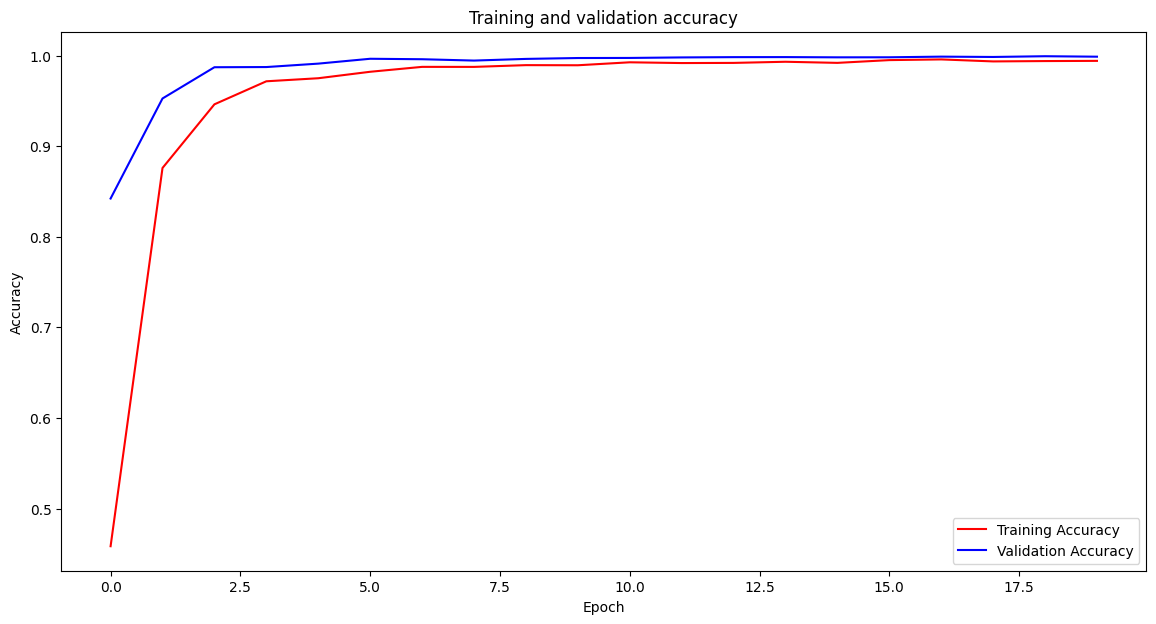

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

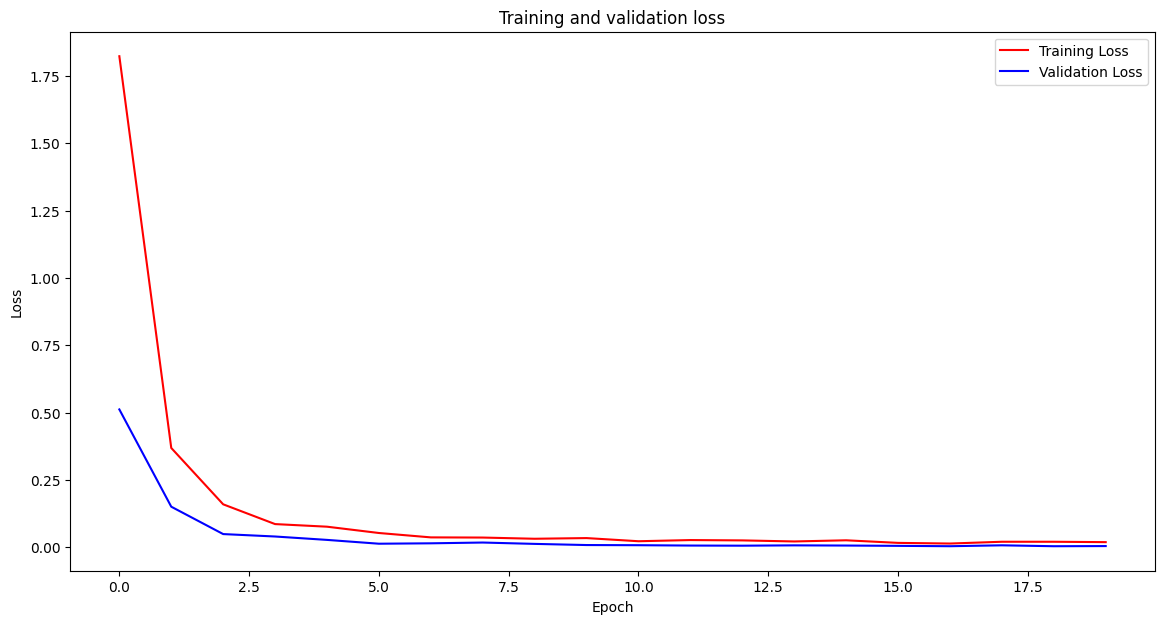

In [19]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [7]:
%load_ext tensorboard
%tensorboard --logdir logs


ModuleNotFoundError: No module named 'tensorboard'

Per visualizzare i log nel dettaglio utilizzare Tensorboard sulla cartella log